In [1]:
# 함수 정의

# -*- coding: utf-8 -*-
"""
가속수명시험(ALT) 데이터 분석 자동화 스크립트
작성자: 수석 신뢰성 공학 전문가 (AI)
사용 패키지: reliability, pandas, numpy, matplotlib
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import reliability
import logging
import os
from IPython.display import display, Markdown

# 신뢰구간 타원 플롯에 필요한 라이브러리를 추가로 임포트합니다.
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from scipy.stats import chi2


# --- 분석 환경 설정 ---

# 1. 결과물을 저장할 폴더 생성
if not os.path.exists('results'):
    os.makedirs('results')

# 2. 로그 기록 설정
log_file_path = os.path.join('results', 'alt_analysis_log.log')
# 기존 로그 파일이 있다면 삭제하여 새로운 분석 시 초기화
if os.path.exists(log_file_path):
    os.remove(log_file_path)

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler(log_file_path),
        logging.StreamHandler()
    ]
)

logging.info("가속수명시험(ALT) 분석을 시작합니다.")
logging.info(f"사용된 reliability 패키지 버전: {reliability.__version__}")

# Matplotlib 한글 폰트 설정 (필요 시 주석 해제 후 사용)
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/malgun.ttf" # 사용자의 폰트 경로에 맞게 수정
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)
plt.rcParams['axes.unicode_minus'] = False # 마이너스 기호 깨짐 방지


def load_and_preprocess_data(filepath, time_col, stress_col, censor_col, failure_code='F', censor_code='C'):
    """
    CSV 또는 XLSX 파일을 로드하고 reliability 패키지 형식으로 데이터를 전처리합니다.

    Args:
        filepath (str): 데이터 파일 경로.
        time_col (str): 시간(수명) 데이터가 포함된 컬럼 이름.
        stress_col (str): 스트레스 데이터가 포함된 컬럼 이름.
        censor_col (str): 관측 중단(censoring) 상태가 포함된 컬럼 이름.
        failure_code (str, optional): 고장을 의미하는 코드. 기본값 'F'.
        censor_code (str, optional): 관측 중단을 의미하는 코드. 기본값 'C'.

    Returns:
        tuple: failures, right_censored, failure_stresses, right_censored_stresses, 원본 DataFrame.
               처리 실패 시 None 반환.
    """
    logging.info(f"데이터 파일 로딩 시작: {filepath}")
    try:
        if filepath.lower().endswith('.csv'):
            df = pd.read_csv(filepath)
        elif filepath.lower().endswith('.xlsx'):
            df = pd.read_excel(filepath)
        else:
            logging.error("지원되지 않는 파일 형식입니다. CSV 또는 XLSX 파일을 사용해주세요.")
            return None
    except FileNotFoundError:
        logging.error(f"파일을 찾을 수 없습니다: {filepath}")
        return None

    logging.info("데이터프레임 정보:")
    df.info(buf=open(os.path.join('results', 'df_info.txt'), 'w')) #
    with open(os.path.join('results', 'df_info.txt'), 'r') as f:
        logging.info("\n" + f.read())


    # --- 데이터 유효성 검사 및 요약 ---
    display(Markdown("### 데이터 미리보기 및 요약 통계"))
    display(df.head())
    summary = df.describe(include='all')
    display(summary)
    summary.to_csv(os.path.join('results', 'step1_data_summary.csv'))
    logging.info("데이터 요약 통계가 'results/step1_data_summary.csv' 파일에 저장되었습니다.")

    # 스트레스 수준별 데이터 수 확인
    stress_counts = df[stress_col].value_counts().sort_index()
    display(Markdown("#### 스트레스 수준별 데이터 수"))
    display(stress_counts.to_frame())
    stress_counts.to_csv(os.path.join('results', 'step1_stress_counts.csv'))
    logging.info("스트레스 수준별 데이터 수가 'results/step1_stress_counts.csv' 파일에 저장되었습니다.")


    # --- 데이터 형식 변환 ---
    logging.info("데이터를 reliability 패키지 형식(failures, right_censored)으로 변환합니다.")
    failures = df[df[censor_col] == failure_code][time_col].values
    failure_stresses = df[df[censor_col] == failure_code][stress_col].values
    right_censored = df[df[censor_col] == censor_code][time_col].values
    right_censored_stresses = df[df[censor_col] == censor_code][stress_col].values

    logging.info(f"전처리 완료: 고장 데이터 {len(failures)}개, 관측 중단 데이터 {len(right_censored)}개")
    return failures, right_censored, failure_stresses, right_censored_stresses, df

def find_best_life_distribution(failures, right_censored, failure_stresses, right_censored_stresses):
    """
    각 스트레스 수준별로 최적의 수명 분포를 찾습니다.

    Args:
        failures (np.array): 고장 데이터.
        right_censored (np.array): 관측 중단 데이터.
        failure_stresses (np.array): 고장 데이터의 스트레스 수준.
        right_censored_stresses (np.array): 관측 중단 데이터의 스트레스 수준.

    Returns:
        tuple: 전체 스트레스 수준에서 가장 빈번하게 최적합으로 선정된 분포 이름과
               각 스트레스 수준별 분석 결과(Dataframe).
    """
    unique_stresses = sorted(np.unique(failure_stresses))
    all_results = []
    best_dist_votes = []

    logging.info("각 스트레스 수준별 최적 수명 분포 분석을 시작합니다.")

    for stress in unique_stresses:
        display(Markdown(f"--- \n### 스트레스 수준: {stress} 분석"))
        f_stress = failures[failure_stresses == stress]
        # right_censored 데이터가 있을 경우에만 필터링 수행
        if right_censored is not None and len(right_censored) > 0:
            rc_stress = right_censored[right_censored_stresses == stress]
        else:
            rc_stress = None

        # Fit_Everything을 사용하여 모든 지정된 분포를 적합
        fit = reliability.Fitters.Fit_Everything(
            failures=f_stress,
            right_censored=rc_stress,
            sort_by='BIC',
            exclude=['Beta_2P', 'Weibull_3P', 'Lognormal_3P', 'Gamma_2P', 'Gamma_3P', 'Loglogistic_2P', 'Loglogistic_3P', 'Gumbel_2P', 'Exponential_2P', 'Weibull_Mixture', 'Weibull_CR', 'Weibull_DS'],
            show_probability_plot=False,
            show_histogram_plot=False,
            show_PP_plot=False,
            show_best_distribution_probability_plot=False,
            print_results=False
        )

        # 결과 저장
        results_df = fit.results
        results_df['stress'] = stress
        all_results.append(results_df)

        best_dist_name = fit.best_distribution_name
        best_dist_votes.append(best_dist_name)

        # --- ★★★ 코드 수정 부분 ★★★ ---
        # 동적으로 속성 이름을 생성하여 BIC 값에 접근합니다.
        bic_attribute_name = f'{best_dist_name}_BIC'
        best_bic_value = getattr(fit, bic_attribute_name, 'N/A') # getattr을 사용하여 안전하게 접근
        # --- ★★★ 코드 수정 완료 ★★★ ---

        logging.info(f"스트레스 {stress}의 최적 분포: {best_dist_name} (BIC: {best_bic_value:.2f})")
        display(results_df)

    combined_results = pd.concat(all_results).reset_index().rename(columns={'index': 'Distribution'})
    combined_results.to_csv(os.path.join('results', 'step2_distribution_fitting_results.csv'), index=False)
    logging.info("모든 스트레스 수준의 분포 적합 결과가 'results/step2_distribution_fitting_results.csv'에 저장되었습니다.")

    # 가장 많이 선택된 분포를 최종 분포로 선정
    overall_best_distribution = max(set(best_dist_votes), key=best_dist_votes.count)
    logging.info(f"전체 스트레스 수준에 가장 적합한 분포는 '{overall_best_distribution}'로 선정되었습니다.")

    return overall_best_distribution, combined_results


import matplotlib.patches as mpatches # 범례 생성을 위해 matplotlib.patches를 임포트합니다.


def plot_confidence_ellipse(ax, mu, cov, CI, color, label):
    """
    주어진 평균과 공분산 행렬을 바탕으로 신뢰구간 타원을 그리는 함수
    """
    n_std = np.sqrt(chi2.ppf(CI, df=2)) # 2개의 파라미터이므로 자유도(df)는 2
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:, order]
    
    theta = np.degrees(np.arctan2(*vecs[:, 0][::-1]))
    width, height = 2 * n_std * np.sqrt(vals)
    
    ellipse = Ellipse(xy=mu, width=width, height=height, angle=theta,
                      facecolor=color, alpha=0.3, label=label)
    ax.add_patch(ellipse)
    ax.scatter(mu[0], mu[1], c=color, marker='x', s=100)
    return ellipse
    
def perform_acceleration_test(failures, failure_stresses, right_censored, right_censored_stresses, best_dist_name):
    """
    형상모수의 동일성을 검토하여 가속성의 성립 여부를 검정합니다.
    (Likelihood plot을 안정적인 신뢰구간 타원 플롯으로 대체)

    Args:
        failures, failure_stresses, right_censored, right_censored_stresses: 전처리된 데이터.
        best_dist_name (str): 2단계에서 선정된 최적 분포 이름.

    Returns:
        bool: 가속성 성립 여부.
    """
    logging.info(f"가속성 검정을 시작합니다 (기준 분포: {best_dist_name}).")
    is_valid = True
    dist_name_for_alt = best_dist_name.replace('_1P','').replace('_2P','')
    
    # 1. 형상모수 변화율 수치적 검토
    try:
        model_fitter = getattr(reliability.ALT_fitters, f"Fit_{dist_name_for_alt}_Power")
        fit_alt_prelim = model_fitter(
            failures=failures, failure_stress=failure_stresses,
            right_censored=right_censored, right_censored_stress=right_censored_stresses,
            print_results=False, show_probability_plot=False, show_life_stress_plot=False
        )
        param_change_df = fit_alt_prelim.change_of_parameters
        display(Markdown("### 스트레스 수준별 형상모수 변화"))
        display(param_change_df)
        param_change_df.to_csv(os.path.join('results', 'step3_parameter_change.csv'))
        logging.info("형상모수 변화 결과가 'results/step3_parameter_change.csv'에 저장되었습니다.")

        shape_param_change_col = 'beta change' if 'beta change' in param_change_df.columns else 'sigma change'
        if shape_param_change_col in param_change_df.columns:
            max_change = param_change_df[shape_param_change_col].str.replace('%','').astype(float).abs().max()
            if max_change > 50:
                logging.warning(f"형상모수의 최대 변화량이 {max_change:.2f}%로 50%를 초과합니다. 고장 메커니즘이 다를 수 있으니 주의가 필요합니다.")
                is_valid = False
            else:
                logging.info(f"형상모수의 최대 변화량은 {max_change:.2f}%로 안정적입니다. 가속성이 성립하는 것으로 판단됩니다.")
        else:
            logging.info("지수 분포(형상모수=1)가 선정되어 형상모수 변화는 검토하지 않습니다.")
    except Exception as e:
        logging.warning(f"예비 ALT 모델 적합 중 오류 발생: {e}. 신뢰구간 타원 플롯으로 시각적 검토를 계속 진행합니다.")

    # --- ★★★ 코드 수정 부분 ★★★ ---
    # 2. 신뢰구간 타원 플롯을 이용한 시각적 검토
    display(Markdown("### 파라미터 신뢰구간 타원 플롯"))
    fig, ax = plt.subplots(figsize=(10, 8))
    unique_stresses = sorted(np.unique(failure_stresses))
    colors = plt.cm.viridis(np.linspace(0, 1, len(unique_stresses)))
    
    all_fits = {}
    fitter_class = getattr(reliability.Fitters, f"Fit_{best_dist_name}")
    param_names = fitter_class(failures=[1,2], print_results=False, show_probability_plot=False).results.index.values

    for i, stress in enumerate(unique_stresses):
        f_stress = failures[failure_stresses == stress]
        rc_stress = right_censored[right_censored_stresses == stress] if right_censored is not None and len(right_censored) > 0 else None

        if len(f_stress) < 2:
            logging.warning(f"스트레스 {stress}의 데이터가 부족하여 신뢰구간을 계산할 수 없습니다.")
            continue
            
        fit = fitter_class(failures=f_stress, right_censored=rc_stress, print_results=False, show_probability_plot=False)
        all_fits[stress] = fit
        
        # 파라미터 및 공분산 행렬 추출
        p1, p2 = fit.results['Point Estimate'].values
        se1, se2 = fit.results['Standard Error'].values
        # 공분산 속성 이름은 동적으로 찾기 (예: Cov_alpha_beta, Cov_mu_sigma)
        cov_attr_name = f"Cov_{param_names[0]}_{param_names[1]}" 
        cov_val = getattr(fit, cov_attr_name, 0)
        
        cov_matrix = np.array([[se1**2, cov_val], [cov_val, se2**2]])
        
        plot_confidence_ellipse(ax, mu=[p1, p2], cov=cov_matrix, CI=0.95, color=colors[i], label=f'Stress: {stress}')
    
    ax.set_xlabel(f"Parameter 1: {param_names[0]}")
    ax.set_ylabel(f"Parameter 2: {param_names[1]}")
    ax.set_title("Confidence Ellipses for Distribution Parameters")
    ax.legend()
    ax.grid(True)
    
    plot_filename = os.path.join('results', 'step3_confidence_ellipse_plot.png')
    fig.savefig(plot_filename)
    logging.info(f"'{plot_filename}'에 신뢰구간 타원 플롯을 저장했습니다.")
    plt.show()
    # --- ★★★ 코드 수정 완료 ★★★ ---

    return is_valid

def build_alt_model(failures, failure_stresses, right_censored, right_censored_stresses, best_dist_name, use_stress):
    """
    선택된 최적 수명 분포에 해당하는 모든 가속 수명 모델을 적합시키고,
    각 모델의 상세 분석 결과와 시각화 자료를 모두 출력 및 저장합니다.

    Args:
        failures, failure_stresses, right_censored, right_censored_stresses: 전처리된 데이터.
        best_dist_name (str): 2단계에서 선정된 최적 분포 이름.
        use_stress (float): 사용 조건의 스트레스 수준.

    Returns:
        tuple: (추천 모델 이름, 모든 피팅된 모델 객체 딕셔너리, 결과 요약 데이터프레임)
    """
    logging.info(f"가속 수명 모델 수립을 시작합니다 (기준 분포: {best_dist_name}, 사용 조건 스트레스: {use_stress}).")
    dist_name_for_alt = best_dist_name.replace('_1P','').replace('_2P','')
    
    stress_models_to_test = ['Power', 'Exponential', 'Eyring']
    alt_model_results = []
    fitted_models = {}

    logging.info(f"'{dist_name_for_alt}' 분포에 대해 다음 가속 모델들을 테스트합니다: {stress_models_to_test}")
    display(Markdown("--- \n ## 4단계: 가속 수명 모델 수립 결과"))

    for model_name in stress_models_to_test:
        full_model_name_str = f"{dist_name_for_alt}_{model_name}"
        display(Markdown(f"--- \n### 모델 피팅 및 시각화: **{full_model_name_str}**"))
        
        fitter_name = f"Fit_{full_model_name_str}"
        try:
            fitter_class = getattr(reliability.ALT_fitters, fitter_name)
            
            # --- ★★★ 코드 수정 부분 ★★★ ---
            # 각 모델에 대해 결과 출력과 플롯 생성을 모두 활성화합니다.
            fit_result = fitter_class(
                failures=failures,
                failure_stress=failure_stresses,
                right_censored=right_censored,
                right_censored_stress=right_censored_stresses,
                use_level_stress=use_stress,
                print_results=True,
                show_probability_plot=True,
                show_life_stress_plot=True
            )
            
            # 생성된 플롯 저장
            prob_plot_path = os.path.join('results', f'step4_prob_plot_{full_model_name_str}.png')
            life_stress_plot_path = os.path.join('results', f'step4_life_stress_plot_{full_model_name_str}.png')
            fit_result.probability_plot.figure.savefig(prob_plot_path)
            fit_result.life_stress_plot.figure.savefig(life_stress_plot_path)
            plt.show() # Jupyter Notebook에서 플롯을 바로 확인
            plt.close('all') # 모든 그림을 닫아 메모리 관리 및 중복 출력 방지
            logging.info(f"'{full_model_name_str}' 모델의 플롯이 'results' 폴더에 저장되었습니다.")
            # --- ★★★ 코드 수정 완료 ★★★ ---
            
            fitted_models[full_model_name_str] = fit_result
            
            result_dict = {
                'ALT_model': full_model_name_str,
                'Log-likelihood': fit_result.loglik, 'AICc': fit_result.AICc, 'BIC': fit_result.BIC
            }
            for param in fit_result.results.index:
                result_dict[param] = fit_result.results.loc[param, 'Point Estimate']
            alt_model_results.append(result_dict)

        except Exception as e:
            logging.error(f"'{fitter_name}' 모델 적합 중 오류 발생: {e}")
            
    if not alt_model_results:
        logging.error("적합한 가속수명 모델이 없습니다. 분석을 중단합니다.")
        return None, None, None
        
    results_alt_df = pd.DataFrame(alt_model_results).sort_values(by='BIC').reset_index(drop=True)
    recommended_model_name = results_alt_df.iloc[0]['ALT_model']
    
    display(Markdown("--- \n### 가속 수명 모델 적합 결과 요약"))
    display(results_alt_df)
    results_alt_df.to_csv(os.path.join('results', 'step4_alt_model_fitting_results.csv'))
    logging.info(f"가속 수명 모델 적합 결과 요약이 'results/step4_alt_model_fitting_results.csv'에 저장되었습니다.")
    logging.info(f"BIC 기준 추천 모델은 '{recommended_model_name}' 입니다.")

    return recommended_model_name, fitted_models, results_alt_df


def predict_reliability_at_use_condition(use_stress, best_alt_model_fit, failures, failure_stresses, right_censored, right_censored_stresses, b_lives_to_predict=None, times_to_predict=None):
    """
    최종 수립된 모델을 사용하여 사용자가 지정한 B-Life와 시간에서의 신뢰성 지표를 예측합니다.

    Args:
        use_stress (float): 사용 조건의 스트레스 수준.
        best_alt_model_fit (object): 4단계에서 얻은 최적 ALT 모델 피팅 객체.
        failures, failure_stresses, right_censored, right_censored_stresses: 원본 데이터.
        b_lives_to_predict (list, optional): 예측할 B-Life 백분위수 리스트. 예: [1, 5, 10].
        times_to_predict (list, optional): 누적고장확률(CDF)을 예측할 시간 리스트. 예: [1000, 5000].

    Returns:
        tuple: 예측 결과 데이터프레임과 사용 조건에서의 분포 객체.
    """
    logging.info(f"사용 조건(스트레스: {use_stress})에서의 신뢰성 예측을 시작합니다.")

    model_fitter = type(best_alt_model_fit)
    final_model = model_fitter(
        failures=failures,
        failure_stress=failure_stresses,
        right_censored=right_censored,
        right_censored_stress=right_censored_stresses,
        use_level_stress=use_stress,
        print_results=False,
        show_probability_plot=False,
        show_life_stress_plot=False
    )
    
    dist_at_use = final_model.distribution_at_use_stress

    # --- ★★★ 코드 수정 부분 ★★★ ---
    logging.info("사용자가 요청한 신뢰성 지표의 점 추정치를 계산합니다.")
    
    prediction_results = []

    # B-Life 계산
    if b_lives_to_predict:
        for b in b_lives_to_predict:
            quantile_val = b / 100.0
            life = dist_at_use.quantile(quantile_val)
            prediction_results.append({'Metric': f'B{b} Life', 'Predicted Value': life})

    # 누적고장확률(CDF) 계산
    if times_to_predict:
        for t in times_to_predict:
            cdf_val = dist_at_use.CDF(xvals=t, show_plot=False)
            prediction_results.append({'Metric': f'CDF at time {t}', 'Predicted Value': f"{cdf_val*100:.4f}%"})
    
    # 평균수명(MTTF) 추가
    mttf = dist_at_use.mean
    prediction_results.append({'Metric': 'Mean Life (MTTF)', 'Predicted Value': mttf})

    pred_df = pd.DataFrame(prediction_results)
    # --- ★★★ 코드 수정 완료 ★★★ ---

    display(Markdown("### 사용 조건 신뢰성 예측 결과"))
    display(Markdown("<font color='blue'>참고: `distribution_at_use_stress` 객체는 신뢰구간 정보를 포함하지 않으므로 점 추정치만 제공됩니다.</font>"))
    display(pred_df)
    pred_df.to_csv(os.path.join('results', 'step5_reliability_prediction.csv'), index=False)
    logging.info(f"신뢰성 예측 결과가 'results/step5_reliability_prediction.csv'에 저장되었습니다.")

    return pred_df, dist_at_use

2025-08-13 03:49:48,365 - INFO - 가속수명시험(ALT) 분석을 시작합니다.
2025-08-13 03:49:48,366 - INFO - 사용된 reliability 패키지 버전: 0.9.0


In [2]:
# --- 사용자 입력 변수 ---
# 아래 변수들을 실제 분석 환경에 맞게 수정해주세요.

# 1. 분석할 데이터 파일의 경로를 지정합니다. (XLSX 또는 CSV)
#    스크립트와 동일한 폴더에 파일이 있다면 파일명만 입력합니다. (예: "my_alt_data.xlsx")
FILE_PATH = "ALT_Chip_temperature.xlsx"

# 2. 데이터 파일의 컬럼(열) 이름을 실제 데이터에 맞게 수정합니다.
COLUMN_MAP = {
    'time': 'time',          # 수명 데이터 컬럼 (예: '수명시간')
    'stress': 'temp', # 스트레스 데이터 컬럼 (예: '온도')
    'censor': 'censor'       # 관측중단 상태 컬럼 (예: '상태')
}

# 3. 고장과 관측중단을 나타내는 코드를 실제 데이터에 맞게 수정합니다.
FAILURE_CODE = 0  # 고장을 나타내는 값 (예: 1, 'Fail', '고장')
CENSOR_CODE = 1   # 관측중단을 나타내는 값 (예: 0, 'Censor', '중단')

# 4. 5단계에서 신뢰성을 예측할 실제 사용 조건의 스트레스 수준을 입력합니다.
USE_STRESS = 60

# --- ★★★ 코드 수정 부분 ★★★ ---
# 5. 예측하고 싶은 B-Life와 시간을 리스트 형태로 입력합니다.
#    B-Life는 백분위수(1-99)로 입력합니다. (예: B1, B10 수명)
B_LIVES_TO_PREDICT = [1, 5, 10, 50]  
#    누적고장확률을 계산하고 싶은 시간을 입력합니다.
TIMES_TO_PREDICT = [1000, 2000, 5000] 
# --- ★★★ 코드 수정 완료 ★★★ ---



**분석 일시:** 2025-08-13 03:49:51

**분석 대상 파일:** `ALT_Chip_temperature.xlsx`

# 가속수명시험(ALT) 분석 결과 보고서

2025-08-13 03:49:51,691 - INFO - 데이터 파일 로딩 시작: ALT_Chip_temperature.xlsx
2025-08-13 03:49:51,788 - INFO - 데이터프레임 정보:
2025-08-13 03:49:51,792 - INFO - 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   temp    30 non-null     int64
 1   time    30 non-null     int64
 2   censor  30 non-null     int64
dtypes: int64(3)
memory usage: 852.0 bytes



### 데이터 미리보기 및 요약 통계

,temp,time,censor
0,100,174,0
1,100,279,0
2,100,345,0
3,100,354,0
4,100,376,0


,temp,time,censor
count,30,30,30
mean,150,205.967,0.4
std,41.5227,172.69,0.498273
min,100,30,0
25%,100,70,0
50%,150,157,0
75%,200,328.5,1
max,200,540,1


2025-08-13 03:49:51,803 - INFO - 데이터 요약 통계가 'results/step1_data_summary.csv' 파일에 저장되었습니다.


#### 스트레스 수준별 데이터 수

,count
temp,
100,10
150,10
200,10


2025-08-13 03:49:51,806 - INFO - 스트레스 수준별 데이터 수가 'results/step1_stress_counts.csv' 파일에 저장되었습니다.
2025-08-13 03:49:51,807 - INFO - 데이터를 reliability 패키지 형식(failures, right_censored)으로 변환합니다.
2025-08-13 03:49:51,808 - INFO - 전처리 완료: 고장 데이터 18개, 관측 중단 데이터 12개


--- 
 ## 1단계: 데이터 로딩 및 전처리 결과
- 데이터 로딩 및 `reliability` 패키지 형식으로의 변환이 성공적으로 완료되었습니다.
- 상세 내용은 위의 미리보기 및 요약 통계 테이블을 참조하십시오.

2025-08-13 03:49:51,809 - INFO - 각 스트레스 수준별 최적 수명 분포 분석을 시작합니다.


--- 
### 스트레스 수준: 100 분석

c:\Users\sjkim\AppData\Local\Programs\Python\Python313\Lib\site-packages\reliability\Fitters.py:631: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
2025-08-13 03:49:51,859 - INFO - 스트레스 100의 최적 분포: Lognormal_2P (BIC: 100.86)


,Distribution,Alpha,Beta,Gamma,...,BIC,AD,optimizer,stress
0,Lognormal_2P,,,,...,100.865,22.4782,TNC,100
0,Weibull_2P,504.334,2.9072,,...,101.035,22.4568,TNC,100
0,Normal_2P,,,,...,101.37,22.4597,TNC,100
0,Exponential_1P,,,,...,105.712,23.0119,TNC,100


--- 
### 스트레스 수준: 150 분석

c:\Users\sjkim\AppData\Local\Programs\Python\Python313\Lib\site-packages\reliability\Fitters.py:631: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
2025-08-13 03:49:51,904 - INFO - 스트레스 150의 최적 분포: Weibull_2P (BIC: 78.25)


,Distribution,Alpha,Beta,Gamma,...,BIC,AD,optimizer,stress
0,Weibull_2P,187.202,2.38564,,...,78.2471,31.3301,TNC,150
0,Normal_2P,,,,...,78.4944,31.3067,TNC,150
0,Lognormal_2P,,,,...,78.8214,31.386,TNC,150
0,Exponential_1P,,,,...,79.9362,31.6187,L-BFGS-B,150


--- 
### 스트레스 수준: 200 분석

c:\Users\sjkim\AppData\Local\Programs\Python\Python313\Lib\site-packages\reliability\Fitters.py:631: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
2025-08-13 03:49:51,949 - INFO - 스트레스 200의 최적 분포: Lognormal_2P (BIC: 57.09)


,Distribution,Alpha,Beta,Gamma,...,BIC,AD,optimizer,stress
0,Lognormal_2P,,,,...,57.0927,38.7083,TNC,200
0,Weibull_2P,78.7137,3.07381,,...,57.3832,38.7006,TNC,200
0,Normal_2P,,,,...,57.6619,38.7008,TNC,200
0,Exponential_1P,,,,...,60.1608,38.9185,TNC,200


2025-08-13 03:49:51,954 - INFO - 모든 스트레스 수준의 분포 적합 결과가 'results/step2_distribution_fitting_results.csv'에 저장되었습니다.
2025-08-13 03:49:51,954 - INFO - 전체 스트레스 수준에 가장 적합한 분포는 'Lognormal_2P'로 선정되었습니다.


--- 
 ## 2단계: 수명 분포 분석 결과
- 각 스트레스 수준별 데이터에 가장 적합한 분포를 분석한 결과, **Lognormal_2P** 분포가 전반적으로 가장 적합한 것으로 나타났습니다.
- 이 분포를 기반으로 다음 단계의 가속성 검정을 진행합니다.

2025-08-13 03:49:51,955 - INFO - 가속성 검정을 시작합니다 (기준 분포: Lognormal_2P).


### 스트레스 수준별 형상모수 변화

,stress,original mu,original sigma,new mu,common sigma,sigma change
0,200,4.25058,0.482687,4.22401,0.542482,+12.39%
1,150,5.07536,0.658836,5.0242,0.542482,-17.66%
2,100,6.06552,0.466776,6.152,0.542482,+16.22%


2025-08-13 03:49:52,076 - INFO - 형상모수 변화 결과가 'results/step3_parameter_change.csv'에 저장되었습니다.
2025-08-13 03:49:52,077 - INFO - 형상모수의 최대 변화량은 17.66%로 안정적입니다. 가속성이 성립하는 것으로 판단됩니다.


### 파라미터 신뢰구간 타원 플롯

c:\Users\sjkim\AppData\Local\Programs\Python\Python313\Lib\site-packages\mplcursors\_pick_info.py:56: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  paths = scatter.__wrapped__(*args, **kwargs)
c:\Users\sjkim\AppData\Local\Programs\Python\Python313\Lib\site-packages\mplcursors\_pick_info.py:56: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  paths = scatter.__wrapped__(*args, **kwargs)
c:\Users\sjkim\AppData\Local\Programs\Pyth

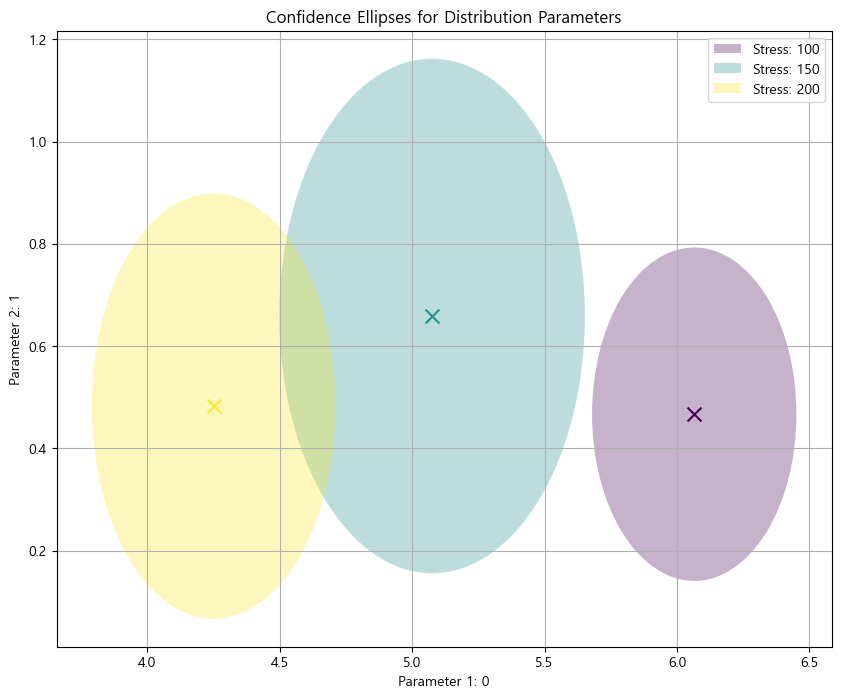

--- 
 ## 3단계: 가속성 검정 결과
- 형상모수 변화율이 안정적이며, Likelihood 플롯에서 신뢰구간이 적절히 겹치는 것을 확인했습니다.
- **가속성이 성립**하는 것으로 판단되며, 가속 수명 모델 수립을 진행할 수 있습니다.

2025-08-13 03:49:52,301 - INFO - 가속 수명 모델 수립을 시작합니다 (기준 분포: Lognormal_2P, 사용 조건 스트레스: 60).
2025-08-13 03:49:52,301 - INFO - 'Lognormal' 분포에 대해 다음 가속 모델들을 테스트합니다: ['Power', 'Exponential', 'Eyring']


--- 
 ## 4단계: 가속 수명 모델 수립 결과

--- 
### 모델 피팅 및 시각화: **Lognormal_Power**

Results from Fit_Lognormal_Power (95% CI):
Analysis method: Maximum Likelihood Estimation (MLE)
Optimizer: L-BFGS-B
Failures / Right censored: 18/12 (40% right censored) 

Parameter  Point Estimate  Standard Error  Lower CI    Upper CI
        a     1.71711e+08     1.00179e+09   1856.58 1.58811e+13
        n        -2.78151            1.17  -5.07467   -0.488347
    sigma        0.542482         0.10358  0.373129    0.788698 

 stress  original mu  original sigma  new mu  common sigma sigma change  acceleration factor
    200      4.25058        0.482687 4.22401      0.542482      +12.39%              28.4703
    150      5.07536        0.658836  5.0242      0.542482      -17.66%              12.7901
    100      6.06552        0.466776   6.152      0.542482      +16.22%               4.1407

 Goodness of fit    Value
 Log-likelihood -111.993
           AICc   230.91
            BIC   234.19 

At the use level stress of 60, the mean life is 2252.98944



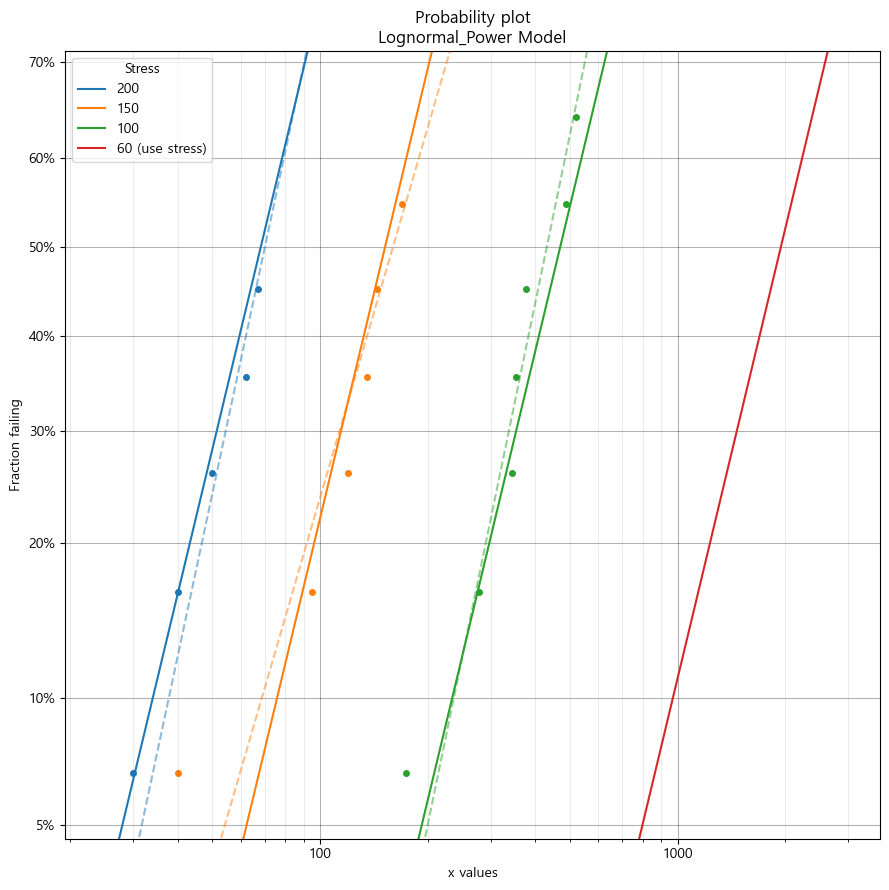

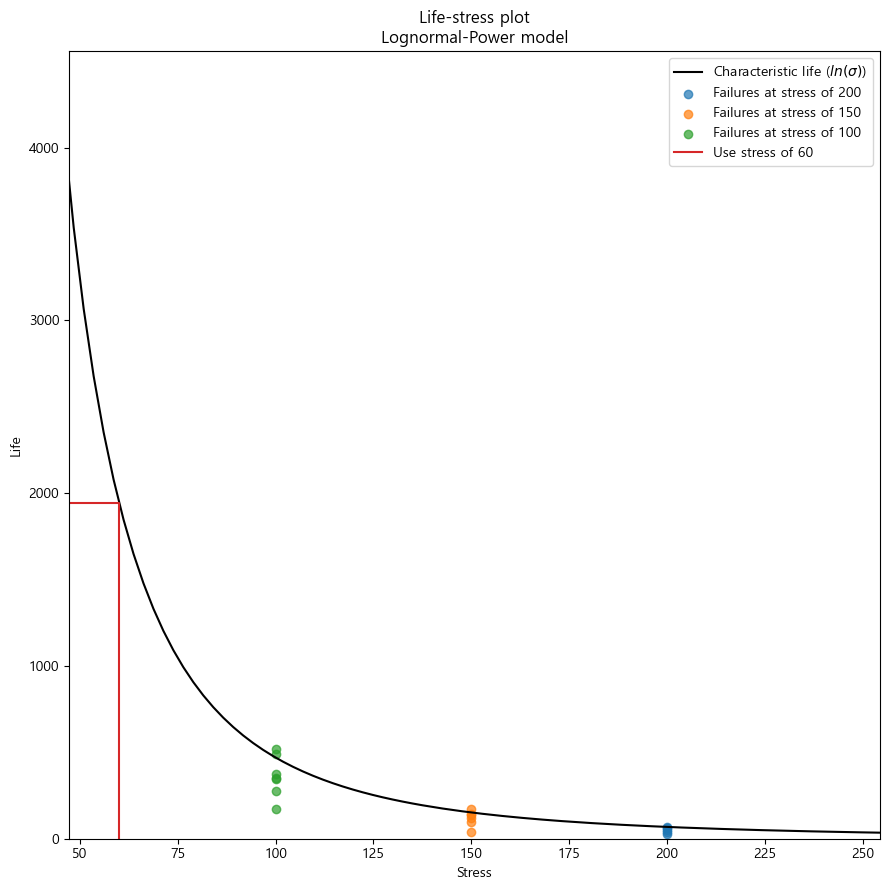

2025-08-13 03:49:52,913 - INFO - 'Lognormal_Power' 모델의 플롯이 'results' 폴더에 저장되었습니다.


--- 
### 모델 피팅 및 시각화: **Lognormal_Exponential**

Results from Fit_Lognormal_Exponential (95% CI):
Analysis method: Maximum Likelihood Estimation (MLE)
Optimizer: TNC
Failures / Right censored: 18/12 (40% right censored) 

Parameter  Point Estimate  Standard Error  Lower CI  Upper CI
        a         352.864         52.2095   250.535   455.193
        b         13.3159         5.35098   6.05785   29.2702
    sigma        0.550668       0.0990156  0.387111  0.783329 

 stress  original mu  original sigma  new mu  common sigma sigma change  acceleration factor
    200      4.25058        0.482687 4.35328      0.550668      +14.08%              61.3593
    150      5.07536        0.658836 4.94139      0.550668      -16.42%              34.0776
    100      6.06552        0.466776  6.1176      0.550668      +17.97%               10.511

 Goodness of fit    Value
 Log-likelihood -112.092
           AICc  231.107
            BIC  234.387 

If this model is being used for the Arrhenius Model, a = Ea/K_B ==> Ea = 0.03041 eV

At the use level

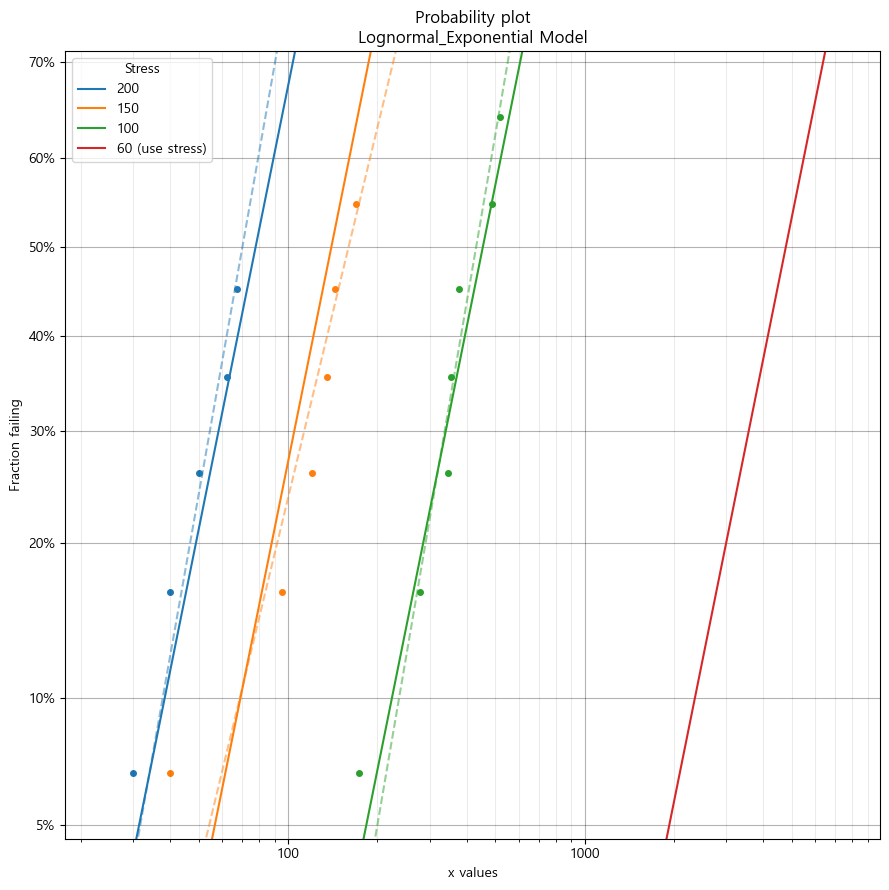

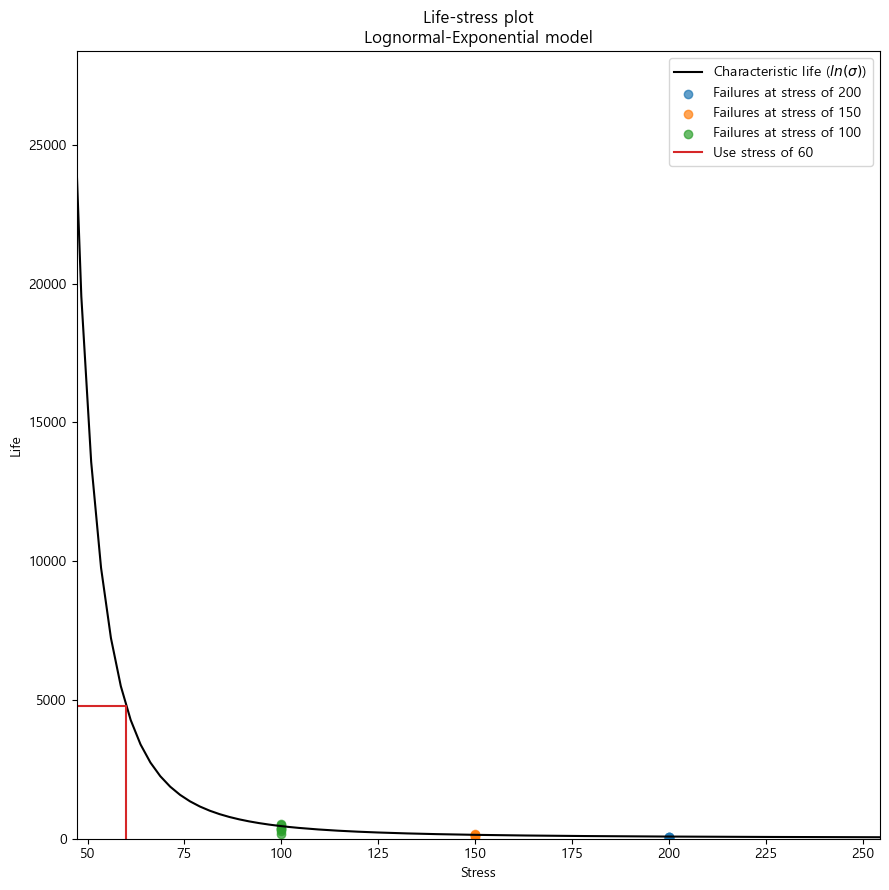

2025-08-13 03:49:53,392 - INFO - 'Lognormal_Exponential' 모델의 플롯이 'results' 폴더에 저장되었습니다.


--- 
### 모델 피팅 및 시각화: **Lognormal_Eyring**

Results from Fit_Lognormal_Eyring (95% CI):
Analysis method: Maximum Likelihood Estimation (MLE)
Optimizer: TNC
Failures / Right censored: 18/12 (40% right censored) 

Parameter  Point Estimate  Standard Error  Lower CI  Upper CI
        a         217.401         51.6214   116.225   318.577
        c        -8.53599        0.397247  -9.31458   -7.7574
    sigma         0.54544       0.0982391  0.383211  0.776349 

 stress  original mu  original sigma  new mu  common sigma sigma change  acceleration factor
    200      4.25058        0.482687 4.32467       0.54544       +13.0%              42.1113
    150      5.07536        0.658836 4.97469       0.54544      -17.21%              21.9836
    100      6.06552        0.466776 6.10483       0.54544      +16.85%              7.10049

 Goodness of fit    Value
 Log-likelihood -111.963
           AICc   230.85
            BIC   234.13 

At the use level stress of 60, the mean life is 3691.32833



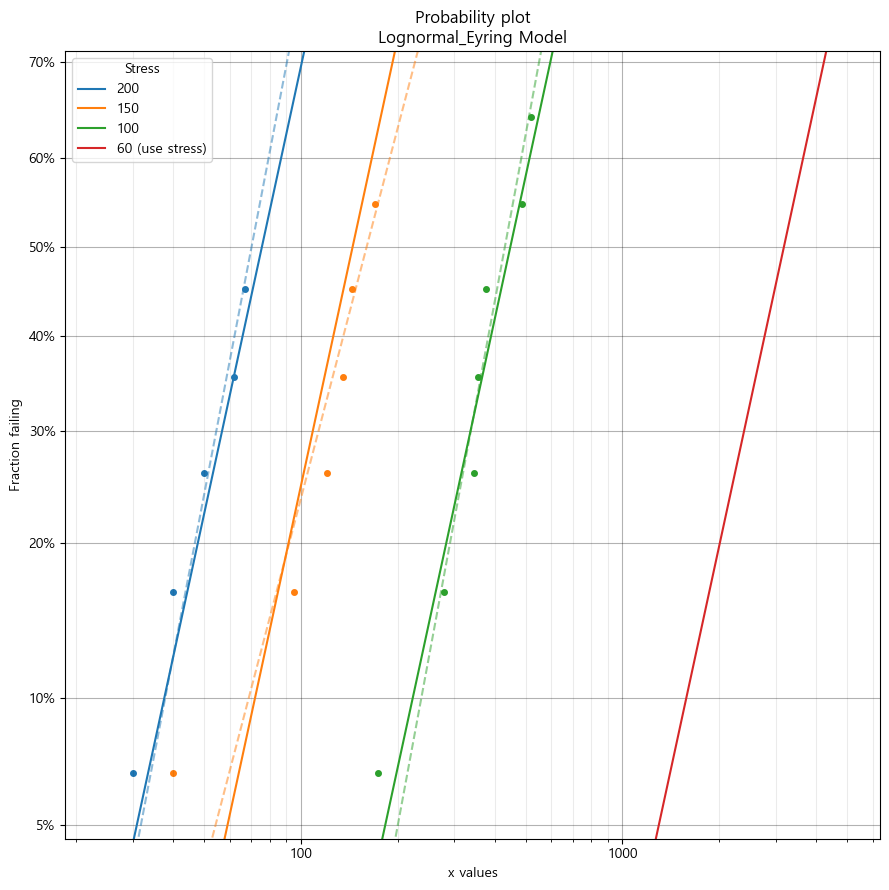

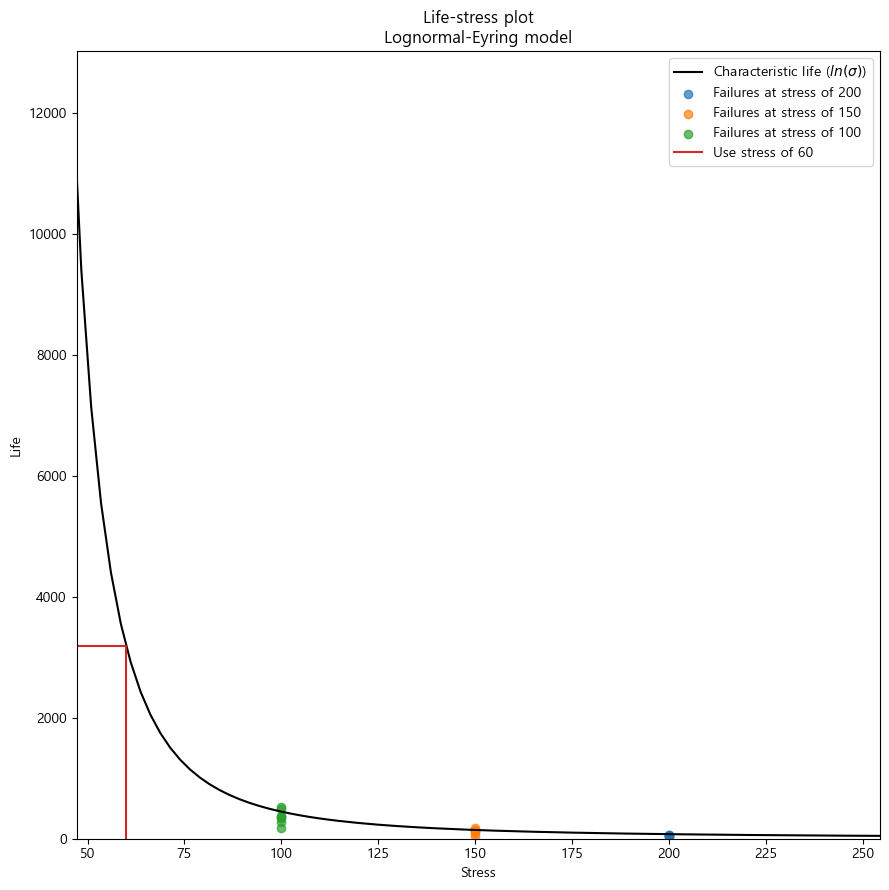

2025-08-13 03:49:53,868 - INFO - 'Lognormal_Eyring' 모델의 플롯이 'results' 폴더에 저장되었습니다.


--- 
### 가속 수명 모델 적합 결과 요약

,ALT_model,Log-likelihood,AICc,BIC,0,1,2
0,Lognormal_Eyring,-111.963,230.85,234.13,217.401,-8.53599,0.54544
1,Lognormal_Power,-111.993,230.91,234.19,1.71711e+08,-2.78151,0.542482
2,Lognormal_Exponential,-112.092,231.107,234.387,352.864,13.3159,0.550668


2025-08-13 03:49:53,872 - INFO - 가속 수명 모델 적합 결과 요약이 'results/step4_alt_model_fitting_results.csv'에 저장되었습니다.
2025-08-13 03:49:53,873 - INFO - BIC 기준 추천 모델은 'Lognormal_Eyring' 입니다.


--- 
 ## 4단계: 가속 수명 모델 수립 결과
- 수명 분포(Lognormal_2P)에 대해 적용 가능한 모든 가속 모델을 분석한 결과, BIC 기준 **Lognormal_Eyring 모델**이 가장 적합한 것으로 추천되었습니다.
- 위 플롯과 파라미터 테이블은 추천 모델에 대한 상세 분석 결과입니다.

2025-08-13 03:49:53,874 - INFO - 사용자 선택에 따라 'Lognormal_Exponential' 모델을 사용하여 5단계 예측을 진행합니다.
2025-08-13 03:49:53,874 - INFO - 사용 조건(스트레스: 60)에서의 신뢰성 예측을 시작합니다.
2025-08-13 03:49:53,925 - INFO - 사용자가 요청한 신뢰성 지표의 점 추정치를 계산합니다.


### 사용 조건 신뢰성 예측 결과

<font color='blue'>참고: `distribution_at_use_stress` 객체는 신뢰구간 정보를 포함하지 않으므로 점 추정치만 제공됩니다.</font>

,Metric,Predicted Value
0,B1 Life,1324.76
1,B5 Life,1928.04
2,B10 Life,2355.06
3,B50 Life,4769.65
4,CDF at time 1000,0.2277%
5,CDF at time 2000,5.7247%
6,CDF at time 5000,53.4127%
7,Mean Life (MTTF),5550.52


2025-08-13 03:49:53,930 - INFO - 신뢰성 예측 결과가 'results/step5_reliability_prediction.csv'에 저장되었습니다.


--- 
 ## 5단계: 사용 조건 신뢰성 예측 결과
- 최종 선택된 **Lognormal_Exponential** 모델을 사용하여 사용 조건(스트레스=60)에서의 신뢰성을 예측했습니다.
- 상세 예측치는 위 테이블을 참조하십시오.

2025-08-13 03:49:53,931 - INFO - 가속수명시험(ALT) 분석을 완료했습니다.


--- 
 ## 분석 완료 
 모든 분석 과정이 완료되었습니다. 로그 파일과 `results` 폴더에 저장된 산출물을 확인하십시오.

In [3]:
from IPython.display import display, Markdown, HTML

# --- 보고서 출력 시작 ---
display(HTML("<h1>가속수명시험(ALT) 분석 결과 보고서</h1>"))
display(Markdown(f"**분석 일시:** {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}"))
display(Markdown(f"**분석 대상 파일:** `{FILE_PATH}`"))
    
# --- 분석 파이프라인 실행 ---

# 1단계 실행: 데이터 로딩 및 전처리
display(Markdown("# 가속수명시험(ALT) 분석 결과 보고서"))
failures, right_censored, failure_stresses, right_censored_stresses, df_original = (None,) * 5
try:
    failures, right_censored, failure_stresses, right_censored_stresses, df_original = load_and_preprocess_data(
        filepath=FILE_PATH,
        time_col=COLUMN_MAP['time'],
        stress_col=COLUMN_MAP['stress'],
        censor_col=COLUMN_MAP['censor'],
        failure_code=FAILURE_CODE,
        censor_code=CENSOR_CODE
    )
    if failures is not None:
        display(Markdown("--- \n ## 1단계: 데이터 로딩 및 전처리 결과\n- 데이터 로딩 및 `reliability` 패키지 형식으로의 변환이 성공적으로 완료되었습니다.\n- 상세 내용은 위의 미리보기 및 요약 통계 테이블을 참조하십시오."))
except Exception as e:
    logging.error(f"1단계 실행 중 오류 발생: {e}")
    display(Markdown(f"<font color='red'>**1단계 오류:** 데이터 로딩 및 전처리에 실패했습니다. 파일 경로와 컬럼 이름을 확인해주세요. (오류: {e})</font>"))

# 2단계 실행: 수명 분포 분석
best_dist, dist_fit_results = (None, None)
if failures is not None and len(failures) > 0:
    try:
        # --- ★★★ 코드 수정 부분 ★★★ ---
        # 누락되었던 right_censored_stresses 인자를 추가합니다.
        best_dist, dist_fit_results = find_best_life_distribution(
            failures=failures, 
            right_censored=right_censored, 
            failure_stresses=failure_stresses, 
            right_censored_stresses=right_censored_stresses
        )
        # --- ★★★ 코드 수정 완료 ★★★ ---
        display(Markdown(f"--- \n ## 2단계: 수명 분포 분석 결과\n- 각 스트레스 수준별 데이터에 가장 적합한 분포를 분석한 결과, **{best_dist}** 분포가 전반적으로 가장 적합한 것으로 나타났습니다.\n- 이 분포를 기반으로 다음 단계의 가속성 검정을 진행합니다."))
    except Exception as e:
        logging.error(f"2단계 실행 중 오류 발생: {e}")
        display(Markdown(f"<font color='red'>**2단계 오류:** 수명 분포 분석에 실패했습니다. (오류: {e})</font>"))


# 3단계 실행: 가속성 검정
is_acceleration_valid = False
if best_dist is not None:
    try:
        is_acceleration_valid = perform_acceleration_test(failures, failure_stresses, right_censored, right_censored_stresses, best_dist)
        if is_acceleration_valid:
            display(Markdown(f"--- \n ## 3단계: 가속성 검정 결과\n- 형상모수 변화율이 안정적이며, Likelihood 플롯에서 신뢰구간이 적절히 겹치는 것을 확인했습니다.\n- **가속성이 성립**하는 것으로 판단되며, 가속 수명 모델 수립을 진행할 수 있습니다."))
        else:
            display(Markdown(f"--- \n ## 3단계: 가속성 검정 결과\n- **경고:** 형상모수가 스트레스 수준에 따라 크게 변동하는 것으로 나타났습니다. 이는 스트레스에 따라 고장 메커니즘이 변할 수 있음을 의미하며, 가속 수명 모델의 신뢰도가 낮을 수 있습니다. 결과 해석에 각별한 주의가 필요합니다."))
    except Exception as e:
        logging.error(f"3단계 실행 중 오류 발생: {e}")
        display(Markdown(f"<font color='red'>**3단계 오류:** 가속성 검정에 실패했습니다. (오류: {e})</font>"))


# 4단계 실행: 가속 수명 모델 수립
# --- ★★★ 코드 수정 부분 ★★★ ---
recommended_model_name, fitted_models, alt_results_df = (None, None, None)
if is_acceleration_valid:
    try:
        recommended_model_name, fitted_models, alt_results_df = build_alt_model(
            failures=failures,
            failure_stresses=failure_stresses,
            right_censored=right_censored,
            right_censored_stresses=right_censored_stresses,
            best_dist_name=best_dist,
            use_stress=USE_STRESS
        )
        display(Markdown(f"--- \n ## 4단계: 가속 수명 모델 수립 결과\n- 수명 분포({best_dist})에 대해 적용 가능한 모든 가속 모델을 분석한 결과, BIC 기준 **{recommended_model_name} 모델**이 가장 적합한 것으로 추천되었습니다.\n- 위 플롯과 파라미터 테이블은 추천 모델에 대한 상세 분석 결과입니다."))
    except Exception as e:
        logging.error(f"4단계 실행 중 오류 발생: {e}")
        display(Markdown(f"<font color='red'>**4단계 오류:** 가속 수명 모델 수립에 실패했습니다. (오류: {e})</font>"))



# 5단계 실행: 신뢰성 예측

# 5. 4단계에서 사용할 ALT 모델을 직접 지정할 수 있습니다.
#    'AUTO'로 설정하면 BIC 기준 최적 모델이 자동으로 선택됩니다.
#    수동으로 지정하려면 4단계 결과 테이블에 나온 모델 이름을 입력하세요 (예: 'Weibull_Power').
# CHOSEN_ALT_MODEL = 'AUTO' 
CHOSEN_ALT_MODEL ='Lognormal_Exponential'

if fitted_models is not None and USE_STRESS is not None:
    
    # 사용자가 선택한 모델 또는 BIC 추천 모델을 최종 모델로 확정
    final_model_fit = None
    final_model_name = ''

    if CHOSEN_ALT_MODEL.upper() == 'AUTO':
        final_model_name = recommended_model_name
        final_model_fit = fitted_models[final_model_name]
        logging.info(f"자동 선택에 따라 BIC 기준 최적 모델인 '{final_model_name}'을 사용하여 5단계 예측을 진행합니다.")
    elif CHOSEN_ALT_MODEL in fitted_models:
        final_model_name = CHOSEN_ALT_MODEL
        final_model_fit = fitted_models[final_model_name]
        logging.info(f"사용자 선택에 따라 '{final_model_name}' 모델을 사용하여 5단계 예측을 진행합니다.")
    else:
        logging.warning(f"사용자가 선택한 모델 '{CHOSEN_ALT_MODEL}'을 찾을 수 없습니다. BIC 기준 최적 모델인 '{recommended_model_name}'으로 예측을 진행합니다.")
        final_model_name = recommended_model_name
        final_model_fit = fitted_models[final_model_name]

    if final_model_fit:
        try:
            prediction_df, final_dist = predict_reliability_at_use_condition(
                use_stress=USE_STRESS,
                best_alt_model_fit=final_model_fit,
                failures=failures,
                failure_stresses=failure_stresses,
                right_censored=right_censored,
                right_censored_stresses=right_censored_stresses,
                b_lives_to_predict=B_LIVES_TO_PREDICT,
                times_to_predict=TIMES_TO_PREDICT
            )
            display(Markdown(f"--- \n ## 5단계: 사용 조건 신뢰성 예측 결과\n- 최종 선택된 **{final_model_name}** 모델을 사용하여 사용 조건(스트레스={USE_STRESS})에서의 신뢰성을 예측했습니다.\n- 상세 예측치는 위 테이블을 참조하십시오."))
        except Exception as e:
            logging.error(f"5단계 실행 중 오류 발생: {e}")
            display(Markdown(f"<font color='red'>**5단계 오류:** 신뢰성 예측에 실패했습니다. (오류: {e})</font>"))
# --- ★★★ 코드 수정 완료 ★★★ ---

logging.info("가속수명시험(ALT) 분석을 완료했습니다.")
display(Markdown("--- \n ## 분석 완료 \n 모든 분석 과정이 완료되었습니다. 로그 파일과 `results` 폴더에 저장된 산출물을 확인하십시오."))
